# Load Data

In [1]:
from os import listdir
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
filepaths = glob.glob("../data/tidy/acetaminophen/*_events_*.csv")
df = pd.concat(map(pd.read_csv, filepaths))
df["CLINICAL_EVENT_DATETIME"] = pd.to_datetime(df["CLINICAL_EVENT_DATETIME"])
df.index = df["CLINICAL_EVENT_DATETIME"]

/home/brian/anaconda3/envs/tsa_course/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [3]:
apap_daily = df.resample("D").count()[["EVENT_ID"]]
apap_daily.columns = ["Doses"]

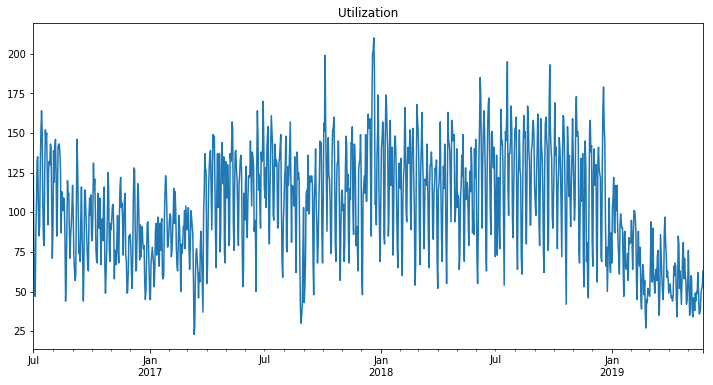

In [4]:
ax = apap_daily.plot(legend=False, figsize=(12, 6), title="Utilization")
ax.autoscale(axis='x',tight=True)
ax.set(xlabel="");

In [5]:
actual_val = apap_daily["Doses"].tail(7)

# ACF

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import lag_plot

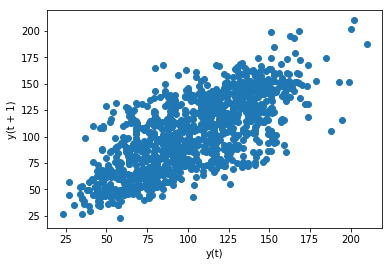

In [7]:
lag_plot(apap_daily["Doses"]);

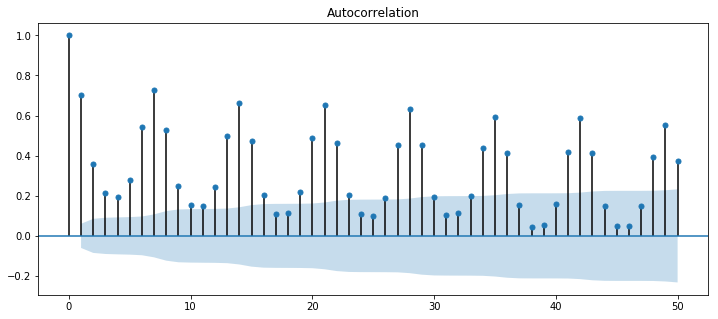

In [8]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(apap_daily["Doses"], lags=50, ax=ax);
#plot_acf(apap_daily);

In [9]:
# data is not stationary; p-value > 0.05
adfuller(apap_daily["Doses"].dropna(), autolag='AIC')[1]

0.33026007407902996

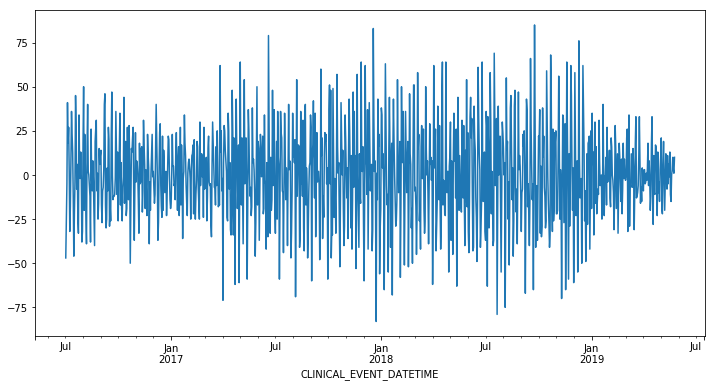

In [10]:
# difference the data to make it stationary
df_diff = apap_daily.copy()
df_diff["Doses"] = diff(apap_daily["Doses"], k_diff=1)
df_diff["Doses"].plot(figsize=(12, 6))

In [11]:
adfuller(df_diff["Doses"].dropna(), autolag='AIC')[1]

2.5300672160926094e-19

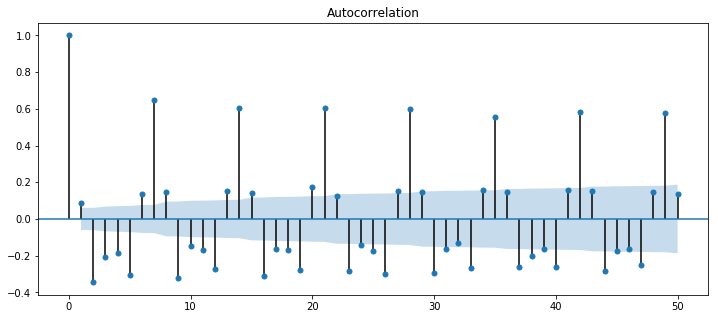

In [12]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df_diff["Doses"].dropna(), lags=50, ax=ax);

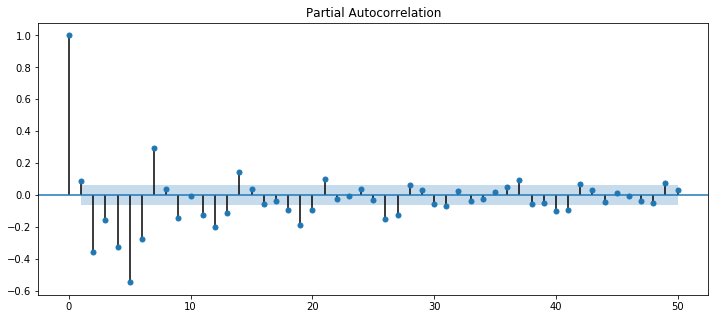

In [13]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(df_diff["Doses"].dropna(), lags=50, ax=ax);

# AR(p) Model

In [14]:
n_pred = 30
l = len(apap_daily) - n_pred
train_set = apap_daily.iloc[:l]
test_set = apap_daily.iloc[l:]

In [15]:
from statsmodels.tsa.ar_model import AR, ARResults
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

In [16]:
model_ar = AR(train_set["Doses"])
fit_ar = model_ar.fit(method="cmle")
print(f'Lag: {fit_ar.k_ar}')

Lag: 21


In [17]:
preds_ar = fit_ar.predict(start=len(train_set), end=len(apap_daily) - 1, dynamic=False).rename('AR Predictions')

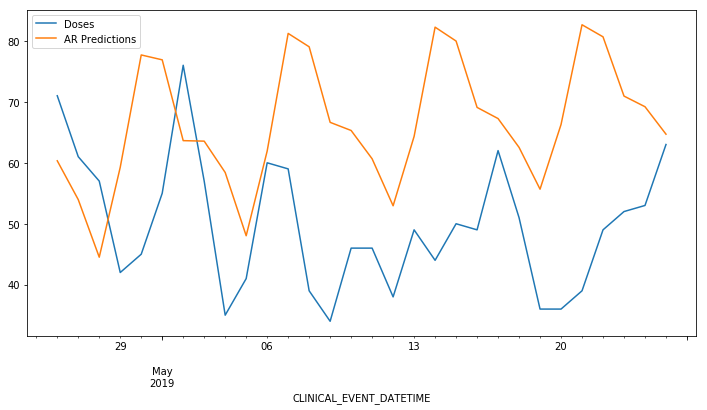

In [18]:
test_set["Doses"].plot(legend=True)
preds_ar.plot(legend=True, figsize=(12, 6));

In [19]:
print(f'MSE: {mean_squared_error(test_set["Doses"], preds_ar):11.10}')
print(f'RMSE: {rmse(test_set["Doses"], preds_ar):11.10}')
print(f'AIC: {fit_ar.aic:6.5}')

MSE: 497.7060194
RMSE: 22.30932584
AIC: 5.6546


## AR Forecast

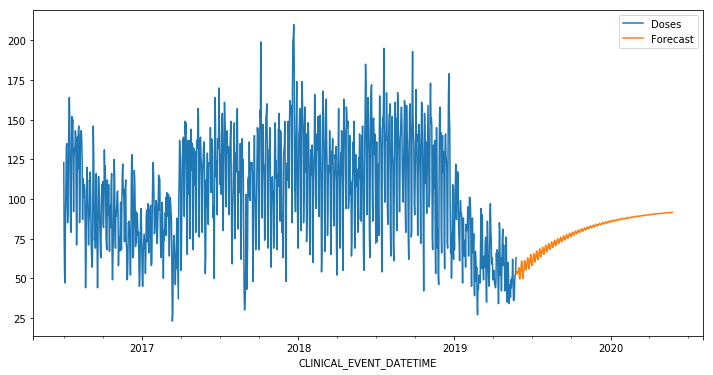

In [20]:
model_ar = AR(apap_daily["Doses"])
fit_ar = model_ar.fit(maxlag=21, method="cmle")
preds_ar = fit_ar.predict(start=len(apap_daily), end=len(apap_daily) + 365, dynamic=False).rename('Forecast')
apap_daily["Doses"].plot(legend=True)
preds_ar.plot(legend=True, figsize=(12, 6));

# ARIMA Models

In [21]:
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from pmdarima import auto_arima

In [22]:
auto_mod = auto_arima(
    apap_daily["Doses"], 
    seasonal=False, 
    stepwise=False,
    maxitr=100, 
    suppress_warnings=True,
    error_action="ignore"
)
auto_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                 1058
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -4430.802
Method:                       css-mle   S.D. of innovations             15.884
Date:                Wed, 29 May 2019   AIC                           8885.605
Time:                        07:21:28   BIC                           8945.174
Sample:                             1   HQIC                          8908.183
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0666      0.063     -1.054      0.292      -0.190       0.057
ar.L1.D.y      1.4016      0.033     41.844      0.000       1.336       1.467
ar.L2.D.y     -1.9233      0.027    -71.223      0.000      -1.976      -1.870
ar.L3.D.y      1.6648      0.048     34.547      0.000       1.570       1.759
ar.L4.D.y     -1.4744      0.027    -55.079      0.000      -1.527      -1.422
ar.L5.D.y      0.5980      0.033     18.067      0.000       0.533       0.663
ma.L1.D.y     -1.7339      0.021    -81.057      0.000      -1.776      -1.692
ma.L2.D.y      2.1236      0.030     70.567      0.000       2.065       2.183
ma.L3.D.y     -2.0636      0.036    -57.245      0.000      -2.134      -1.993
ma.L4.D.y      1.6248      0.031     51.861      0.000       1.563       1.686
ma.L5.D.y     -0.8576      0.019    -44.126      0.000      -0.896      -0.820
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.2227           -0.9764j            1.0015           -0.2857
AR.2           -0.2227           +0.9764j            1.0015            0.2857
AR.3            0.6237           -0.7832j            1.0012           -0.1430
AR.4            0.6237           +0.7832j            1.0012            0.1430
AR.5            1.6633           -0.0000j            1.6633           -0.0000
MA.1           -0.2252           -0.9967j            1.0218           -0.2854
MA.2           -0.2252           +0.9967j            1.0218            0.2854
MA.3            1.0567           -0.0000j            1.0567           -0.0000
MA.4            0.6441           -0.8012j            1.0280           -0.1422
MA.5            0.6441           +0.8012j            1.0280            0.1422
-----------------------------------------------------------------------------
"""

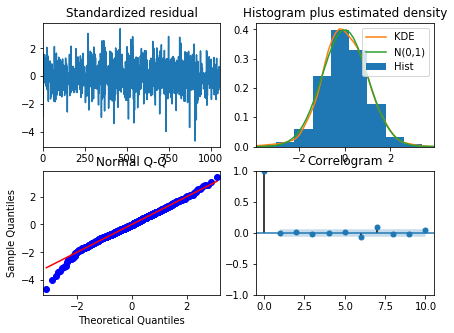

In [23]:
auto_mod.plot_diagnostics(figsize=(7,5))
plt.show()

In [24]:
model_arima = ARIMA(train_set["Doses"], order=(5, 1, 5))
fit_arima = model_arima.fit()
#print(fit_arima.summary())

In [25]:
fc, se, conf = fit_arima.forecast(n_pred, alpha=0.05)  # 95% conf
fc_series = pd.Series(fc, index=test_set.index)
lower_series = pd.Series(conf[:, 0], index=test_set.index)
upper_series = pd.Series(conf[:, 1], index=test_set.index)

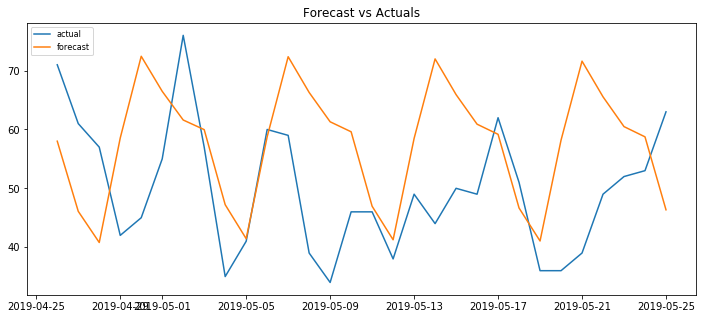

In [26]:
plt.figure(figsize=(12, 5))
#plt.plot(train_set, label='training')
plt.plot(test_set, label='actual')
plt.plot(fc_series, label='forecast')
#plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [27]:
print(f'MSE: {mean_squared_error(test_set["Doses"], fc_series):11.10}')
print(f'RMSE: {rmse(test_set["Doses"], fc_series):11.10}')

MSE: 252.6324597
RMSE: 15.89441599


In [28]:
model_arima = ARIMA(apap_daily["Doses"], order=(5, 1, 5))
fit_arima = model_arima.fit()
#preds_arima = fit_arima.predict(start=len(apap_daily), end=len(apap_daily) + 30, dynamic=False).rename('Forecast')

In [29]:
n_pred = 90
fc, se, conf = fit_arima.forecast(n_pred, alpha=0.05)  # 95% conf
idx = pd.date_range(apap_daily.index[-1] + 1, periods = n_pred, freq="D")
fc_series = pd.Series(fc, index=idx)
lower_series = pd.Series(conf[:, 0], index=idx)
upper_series = pd.Series(conf[:, 1], index=idx)

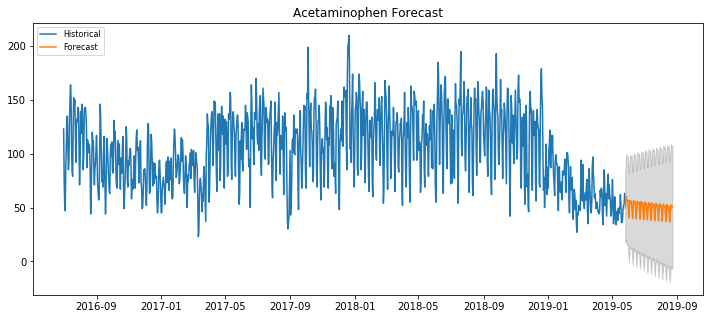

In [30]:
#apap_daily["Doses"].plot(legend=True)
#preds_arima.plot(legend=True, figsize=(12, 6));
plt.figure(figsize=(12, 5))
plt.plot(apap_daily, label='Historical')
plt.plot(fc_series, label='Forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=0.15)
plt.title('Acetaminophen Forecast')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [32]:
print(f'RMSE: {rmse(actual_val, [43, 54, 61, 56, 55, 56, 45]):11.10}')

RMSE: 13.35236737


In [33]:
fc_series[0:7]

2019-05-26    49.627253
2019-05-27    54.529623
2019-05-28    60.331182
2019-05-29    56.342870
2019-05-30    55.685540
2019-05-31    56.852287
2019-06-01    47.460553
Freq: D, dtype: float64